<h1 align="center" style="font-variant: small-caps">Tutorial: How to build a genome-scale GBA model</h1>
<h2 align="center">STEP 5: Model size reduction</h2>
<h5 align="center">(<code>Version 7</code>, March 2025)</h5>

<div align="center" style="max-width:100px;display:block;margin:auto;">

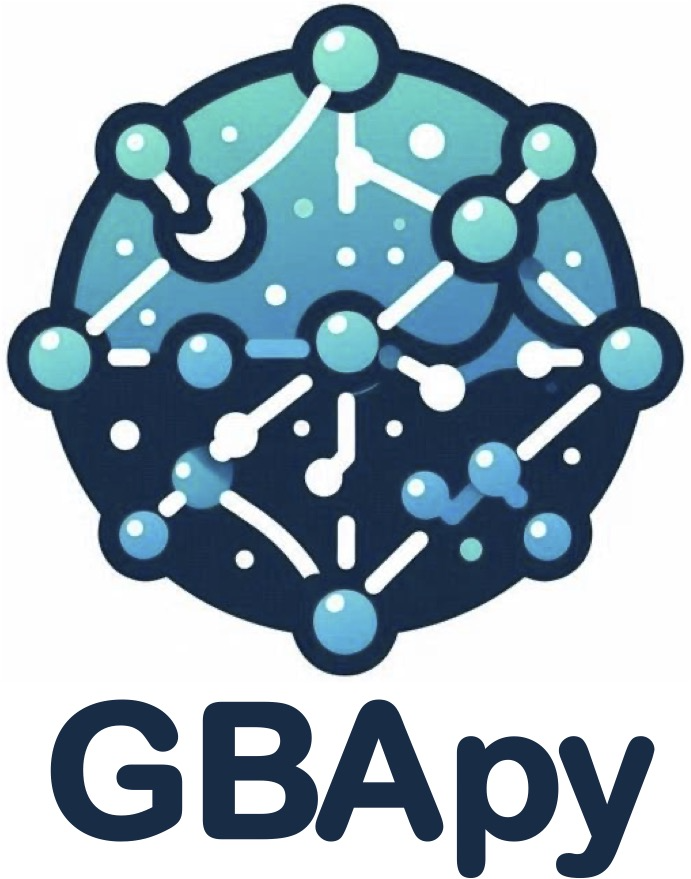

</div>

# Table of contents <a id="table_of_contents"></a>

- [1. Objective](#objective)
- [2. Load the model builder](#load)
- [3. Create a function to automatically set up, build and test a GBA model](#build)
- [4. Check the list of inactive reactions in the original model](#check_FBA_inactive)
- [5. Remove the list of FBA inactive reactions](#remove_FBA_inactive)
- [6. Remove inactive reactions in the GBA solution](#remove_GBA_inactive)
- [7. Preliminary result](#result)

# In summary

<div align="center" style="max-width:850px;display:block;margin:auto;">

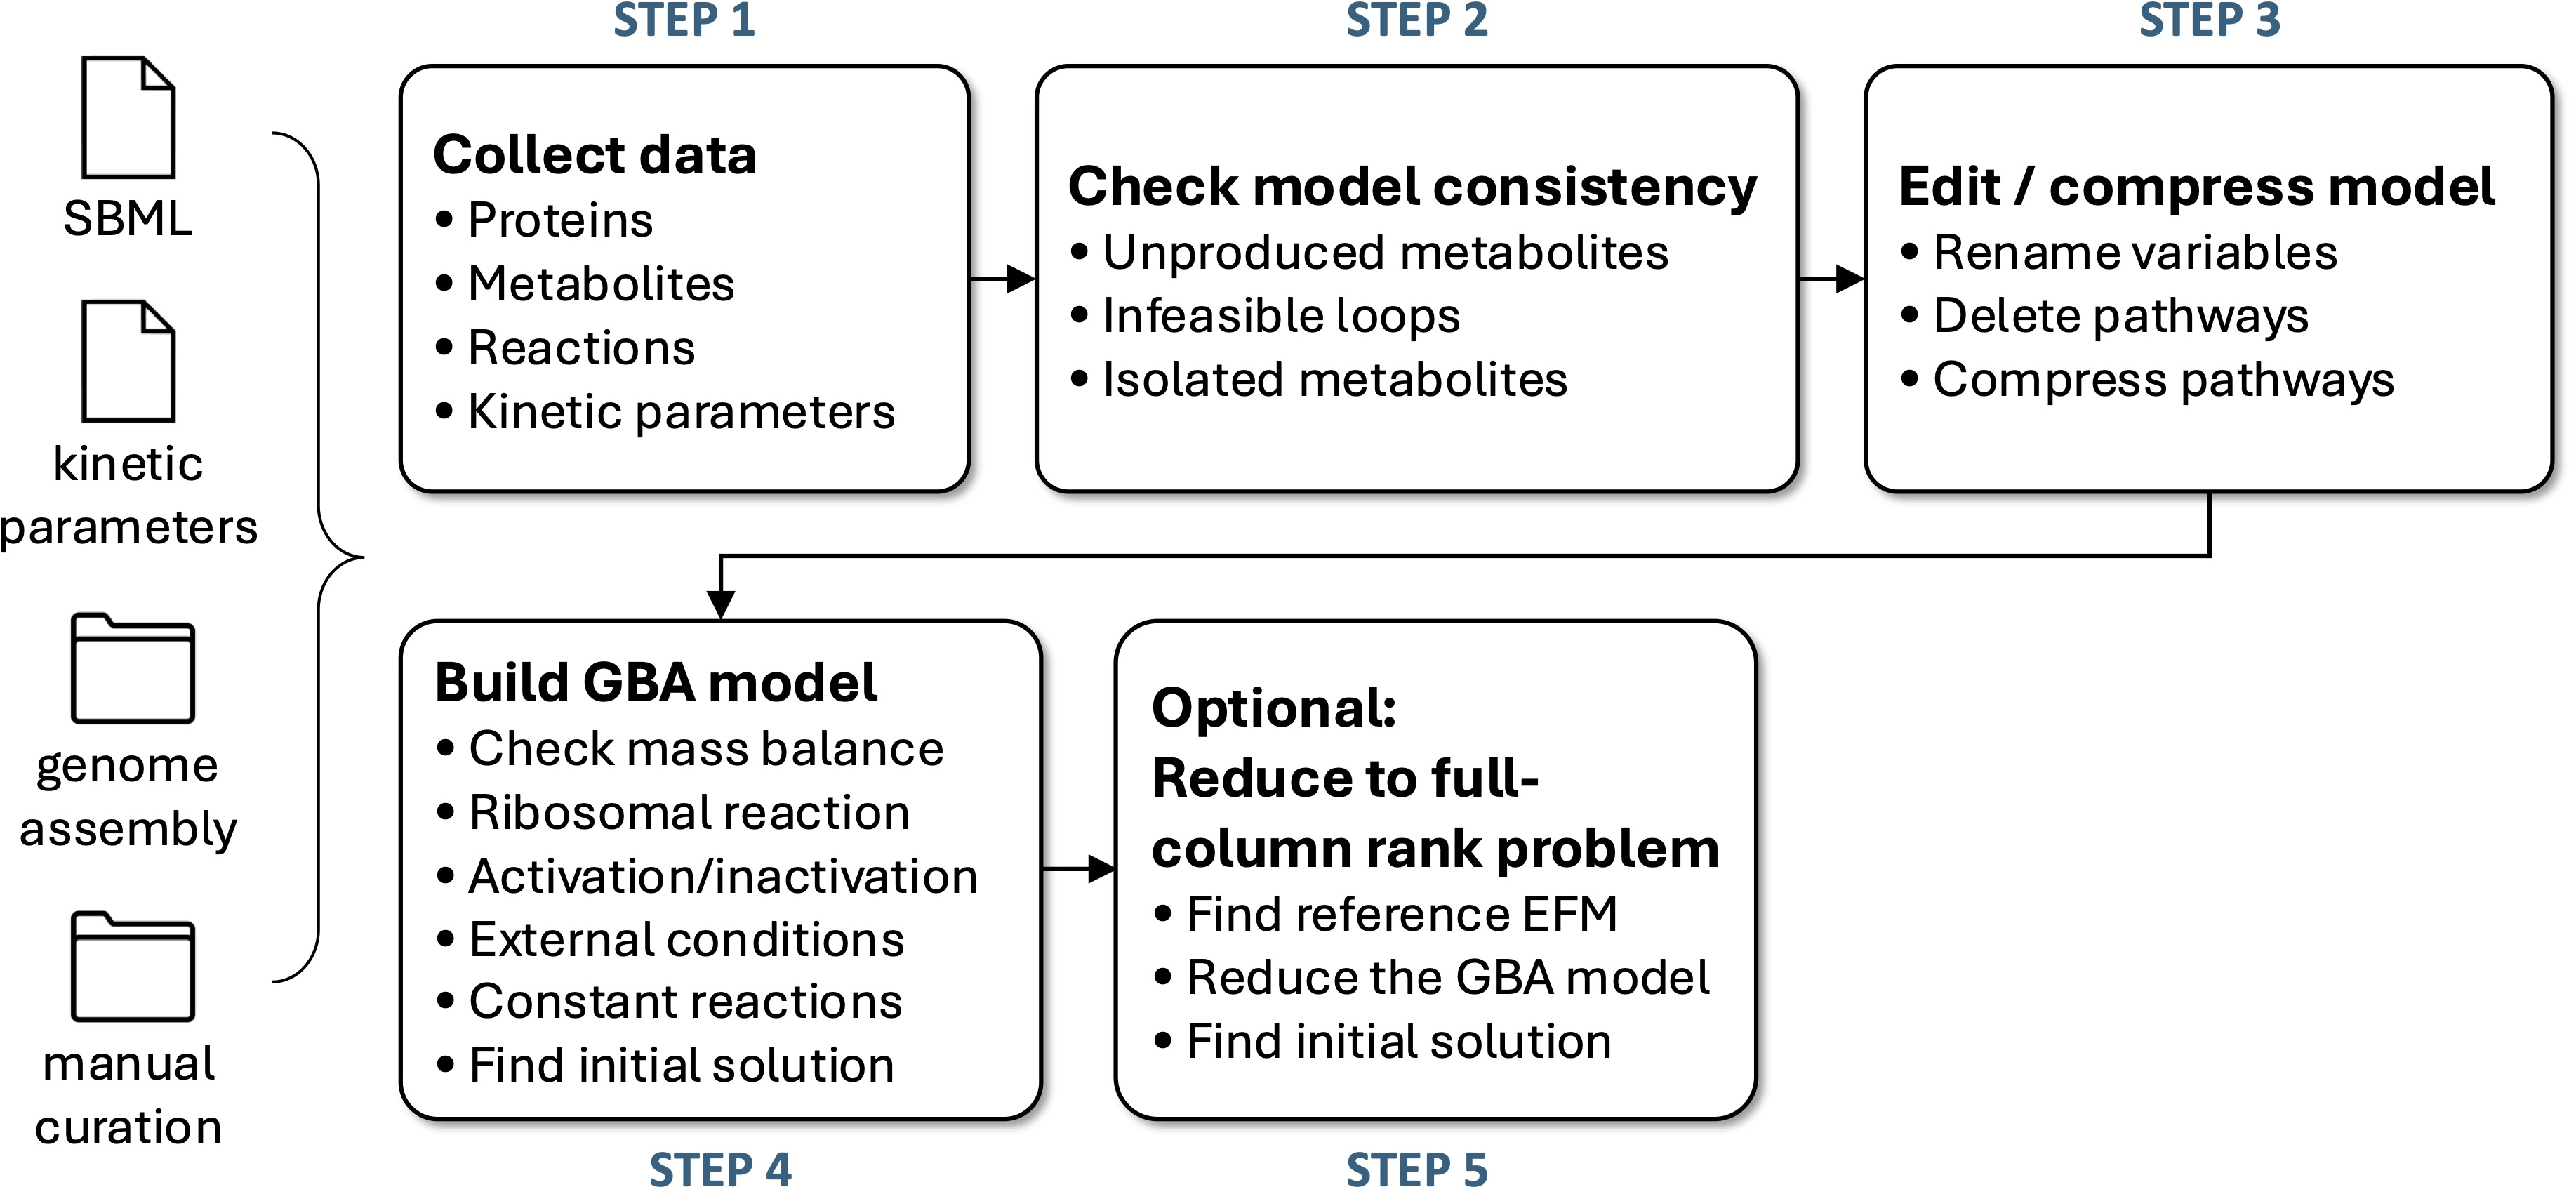

</div>

<div align="center">
<strong>At the beginning of each step of the tutorial, the GBApy methods used are listed</strong>.
</div>

# 1. Objective <a id="objective"></a>

[&#10148; Back to the table of contents](#table_of_contents)

In the previous tutorial (step 4), we finalized a near complete version of the minimal cell and obtained what appears to be a correct initial solution. However, such a model cannot be optimized easily as its matrix is not full column rank (see below). Indeed, it has been shown that if the matrix is full column rank, the problem is proven to be convex, with a single optimal solution. This is usually the case when the matrix contains a single elementary flux mode (EFM).

In this tutorial, we will reduce the model to obtain a full column rank and consistent GBA model. We will do it in two steps:
- <strong>(1)</strong> Find an EFM and remove inactive reactions. Many approaches can be used to obtain an EFM (<em>e.g.</em> FBA, pFBA, Gecko, or RBA approaches). As a first approach, we will use a standard FBA optimization,
- <strong>(2)</strong> Run the GBA model to an optimum, and remove remaining inactive reactions to reach a EFM into the GBA model.

# 2. Load the model builder <a id="load"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.load_gba_builder( path )</code> | Load a GBA builder from a backup |

</div>

The GBA builder is loaded from the backup created in step 3.
We also re-load the original SBML model of a minimal cell.

In [1]:
from gba.Enumerations import *
from gba.Species import *
from gba.Reaction import *
from gba.GbaBuilder import *
from gba.GbaModel import *

import cobra

builder    = load_gba_builder("backup/mmsyn_build_3.gbabuild")
sbml_model = cobra.io.read_sbml_model("data/manual_curation/MMSYN_annotated.xml")

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-15
Read LP format model from file /var/folders/5h/n0xqh1xj2zg6yyd747k95bc80000gn/T/tmpxmtyjomz.lp
Reading time = 0.00 seconds
: 156 rows, 376 columns, 1558 nonzeros


# 3. Create a function to automatically set up and build a GBA model <a id="build"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.GbaBuilder.check_model( test_structure )</code> | Test the consistency of the GBA build |
| <code>gba.GbaBuilder.adjust_masses( metabolites )</code> | Adjust masses from a list of positive or negative corrections |
| <code>gba.GbaBuilder.check_mass_balance( verbose )</code> | Check the mass balance of each reaction of the model |
| <code>gba.GbaBuilder.convert( ribosome_byproducts )</code> | Convert all model units to GBA units |
| <code>gba.GbaBuilder.build_GBA_variables()</code> | Build the GBA variables |
| <code>gba.GbaBuilder.clear_conditions()</code> | Delete all the external conditions of the GBA model |
| <code>gba.GbaBuilder.add_condition( condition_id, rho, default_concentration, metabolites )</code> | Add an external condition to the GBA model |
| <code>gba.GbaBuilder.add_activation_constant( metabolite_id, reaction_id, value )</code> | Add an activator metabolite to a reaction |
| <code>gba.GbaBuilder.add_constant_rhs( metabolite_id, value )</code> | Add a constant RHS term for the initial solution |
| <code>gba.GbaBuilder.clear_constant_reactions()</code> | Remove the list of constant reactions |
| <code>gba.GbaBuilder.add_constant_reaction( reaction_id, value )</code> | Set up a reaction as constant |
| <code>gba.GbaBuilder.enforce_directionality( flux_vector )</code> | Enforce the directionality of the GBA model given a flux vector |
| <code>gba.backup_gba_builder( builder, name, path )</code> | Backup a GBA builder |
| <code>gba.GbaBuilder.export_GBA_model( path )</code> | Export the GBA model in CSV format |
| <code>gba.GbaBuilder.create_GBA_model( name, verbose )</code> | Create a GBA model (class GbaModel) from the builder |
| <code>gba.GbaModel.solve_local_linear_problem( rhs_factor )</code> | Use a LP routine to find one initial solution to the GBA model |
| <code>gba.GbaModel.set_condition( condition_id )</code> | Set the external condition of the model |
| <code>gba.GbaModel.set_f0( f )</code> | Set the initial point of the GBA model |
| <code>gba.GbaModel.calculate_state()</code> | Calculate the current state of the GBA model |
| <code>gba.GbaModel.check_model_consistency()</code> | Check the consistency of the GBA model |
| <code>gba.GbaModel.save_f0( path )</code> | Save the initial point in CSV format |

</div>

First, we create a function to automatically set up the GBA model properties (activators, constant fluxes, etc), build it, and find an initial solution.

This function will also print the column rank of the internal $M$ matrix, and if this matrix is full column rank.

In [2]:
def build_GBA_model( builder, sbml_model, max_flux_fraction, rhs_factor, adjust_mass, add_byproducts, consider_proteome_fraction, add_activators, model_name ):
    builder.check_model(test_structure=True)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 1) Adjust metabolite masses               #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    mass_adjustement                 = {}
    mass_adjustement["x_AA"]         = 17.007345999998506
    mass_adjustement["AA"]           = 17.007345999998506
    mass_adjustement["tRNA"]         = -94.58300315200177
    mass_adjustement["AAtRNA"]       = -94.58300315200177
    mass_adjustement["rRNA"]         = -1546.343817033805
    mass_adjustement["dUTPase"]      = 2600.639
    mass_adjustement["apoACP"]       = 1752.813
    mass_adjustement["ACP"]          = 1752.813
    mass_adjustement["ACP_R"]        = 1757.909
    mass_adjustement["PdhC"]         = 12940.79
    mass_adjustement["lpl_PdhC"]     = 12934.08
    mass_adjustement["acdhlpl_PdhC"] = 12934.08
    mass_adjustement["dhlpl_PdhC"]   = 12934.08
    mass_adjustement["Protein"]      = 8932.936
    mass_adjustement["x_5fthf"]      = 292.2431019999999
    mass_adjustement["5fthf"]        = 292.2431019999999
    mass_adjustement["fmettrna"]     = -96.15291
    mass_adjustement["lgltn"]        = 7.5569999999988795
    mass_adjustement["cdpdag"]       = 0.13765799800012246
    mass_adjustement["dnad"]         = 0.31494099599990477
    mass_adjustement["thfglu3"]      = 30.026026999999885
    if adjust_mass:
        print("> Adjusting masses")
        builder.adjust_masses(mass_adjustement)
    builder.check_mass_balance(verbose=True)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 2) Convert to GBA units                   #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    if add_byproducts and not consider_proteome_fraction:
        print("> Adding ribosome byproducts")
        builder.convert(ribosome_byproducts=True)
    elif add_byproducts and consider_proteome_fraction:
        print("> Adding ribosome byproducts and proteome fraction")
        builder.convert(ribosome_byproducts=True, consider_proteome_fraction=True)
    elif not add_byproducts and not consider_proteome_fraction:
        builder.convert()
    elif not add_byproducts and consider_proteome_fraction:
        print("> Adding proteome fraction")
        builder.convert(consider_proteome_fraction=True)
    builder.build_GBA_variables()
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 3) Show the column rank of the matrix     #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    x1 = builder.GBA_column_rank
    x2 = builder.GBA_intM.shape[1]
    print("> Column rank", x1, "/", x2, "( diff =", x2-x1, ")")
    if builder.GBA_is_full_column_rank:
        print("> Matrix is full column rank")
    print("> Dependent reactions:", builder.GBA_dependent_reactions)
    print("> internal M shape:", builder.GBA_intM.shape)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 3) Add conditions                         #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # (1) Load the medium composition from Thrornburg et al. (2022)
    f           = open("./data/Thornburg-et-al-2022/simulation_medium.csv", "r")
    l           = f.readline()
    l           = f.readline()
    metabolites = {}
    while l:
        l    = l.strip("\n").split(";")
        m_id = l[1]
        conc = float(l[4])
        if m_id in builder.metabolites:
            metabolites[m_id] = conc*0.001*builder.metabolites[m_id].mass
        l = f.readline()
    f.close()
    # (2) Complete the medium composition
    metabolites["x_h2o"] = 1000.0
    metabolites["x_h"]   = 1e-7
    # (3) Create external conditions with an external glucose gradient
    added_glucose     = [0.0, 1e-05, 0.0001, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0, 2.5, 5.0, 7.5, 10.0]
    CMRL_1066_glucose = 0.4
    builder.clear_conditions()
    for i in range(len(added_glucose)):
        glucose                 = added_glucose[i] + CMRL_1066_glucose
        metabolites["x_glc__D"] = glucose
        builder.add_condition(condition_id=str(i+1), rho=1100.0, default_concentration=1.0, metabolites=metabolites)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 4) Add activator metabolites              #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    if add_activators:
        print("> Adding activators")
        builder.add_activation_constant("DNA", "DNAP", 16.94)
        builder.add_activation_constant("DNA", "rRNAP", 16.94)
        builder.add_activation_constant("DNA", "tRNAP", 16.94)
        builder.add_activation_constant("rRNA", "Ribosome", 50.12392)
        builder.add_constant_rhs("DNA", 0.055*(1-0.72))
        builder.add_constant_rhs("rRNA", 0.16274*(1-0.72))
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 5) Add constant H20                       #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    builder.clear_constant_reactions()
    builder.add_constant_reaction("H2Ot", 0.72)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 6) Enforce directionality                 #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    sol = sbml_model.optimize()
    builder.enforce_directionality(sol.fluxes)
    print("> Proteome fraction:", builder.GBA_modeled_proteome_fraction)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 7) Export the GBA build                   #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    backup_gba_builder(builder, "mmsyn_build_5", "./backup")
    builder.export_GBA_model("./models", model_name)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 8) Load the GBA model                     #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    model = builder.create_GBA_model(model_name, True)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # 9) Find an initial solution               #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    solved = model.solve_local_linear_problem(max_flux_fraction=max_flux_fraction, rhs_factor=rhs_factor)
    if solved:
        model.set_condition("1")
        model.set_f0(model.LP_solution)
        model.calculate_state()
        model.check_model_consistency()
        if model.consistent:
            print("> Model is consistent with mu =", model.mu)
            model.save_f0(path="./models")
        else:
            print("> Model is inconsistent")
    else:
        print("> Impossible to find an initial solution")

# 4. Check the list of inactive reactions in the reconstructed FBA solution <a id="check_FBA_inactive"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.GbaBuilder.build_FBA_model( enforced_reactions )</code> | Reconstruct an FBA version of the model, given an optional list of reactions with enforced values |

</div>

To detect inactive reactions in the FBA solution, we first reconstruct the FBA model (remember the FBA biomass function has been already defined in a previous step). To increase the realism of the solution, we enforce positive values for production reactions.

We find 34 inactive reactions. When all these reactions will be removed, we will have reached a FBA elementary flux mode (EFM).

In [3]:
enforced_reactions = {"tRNAP": 1e-8,
                      "rRNAP": 1e-8,
                      "ACP_transl": 1e-8,
                      "PdhC_transl": 1e-8,
                      "dUTPase_transl": 1e-8}
builder.build_FBA_model(enforced_reactions)
print(">", len(builder.inactive_reactions), "reactions to remove")
builder.inactive_reactions

> 34 reactions to remove


['ACALDt',
 'ADEt2',
 'ADNabc',
 'CTPDP',
 'CTPSDUMP',
 'DCDPMP',
 'DCMPDA',
 'DCTPDP',
 'DCTPMP',
 'DRPA',
 'DURIK1',
 'DURIabc',
 'DUTPDP',
 'GAPDP',
 'GUAt2',
 'NADK',
 'NAt3',
 'NTD1',
 'NTD5',
 'NTD6',
 'NTD8',
 'NTD9',
 'PDH_acald',
 'PGK2',
 'PGK4',
 'PPM2',
 'PUNP1',
 'PYK3',
 'PYK9',
 'PYRt2r',
 'RNDR1',
 'RNDR2',
 'RNDR3',
 'RNDR4']

# 5. Remove the list of FBA inactive reactions <a id="remove_FBA_inactive"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.GbaBuilder.reset_conversion()</code> | Reset the conversion to GBA units |
| <code>gba.GbaBuilder.remove_reaction()</code> | Remove a reaction from the GBA builder |
| <code>gba.GbaBuilder.remove_metabolite()</code> | Remove a metabolite from the GBA builder |
| <code>gba.GbaBuilder.build_FBA_model( enforced_reactions )</code> | Reconstruct an FBA version of the model, given an optional list of reactions with enforced values |

</div>

We will now remove all these reactions pathway by pathway.

In [4]:
builder.reset_conversion()

# Remove deoxyuridine metabolism
metabolites = ["x_duri", "duri"]
reactions   = ["DURIabc", "DURIK1", "NTD1", "DCMPDA", "CTPSDUMP"]
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# Remove acetaldehyde metabolism
metabolites = ["x_acald", "acald", "2dr5p"]
reactions   = ["PDH_acald", "PPM2", "DRPA", "ACALDt"]
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# Remove the DCTPMP reaction
reactions = ["DCTPMP"]
builder.remove_reactions(reactions)

# Remove inactive transporters
reactions = ["ADEt2", "GUAt2", "NAt", "NAt3", "L_LACt2r"]# , "GSNabc"
metabolites = ["x_ade", "x_gua", "x_na1", "na1", "x_lac__L"] # , "x_gsn"
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# Other internal inactive reactions
reactions = ["LDH_L"]
metabolites = ["lac__L"]
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# NTD reactions
reactions = ["NTD5", "NTD6", "NTD8", "NTD9"]
metabolites = []
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# PUNP reactions
reactions = ["PUNP2", "PUNP4"]#, "PUNP3"]
metabolites = ["2dr1p"] # "gsn"
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# RNDR reactions
reactions = ["RNDR1", "RNDR2", "RNDR3", "RNDR4"]
metabolites = []
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# PYK reactions
reactions = ["PYK9", "PYK3"]
metabolites = ["dudp", "dutp"]
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# PGK reactions
reactions = ["PGK2", "PGK4"]
metabolites = []
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# Nucleotides metabolism
reactions = ["DUTPDP", "CTPDP", "DCDPMP", "DCTPDP"]
metabolites = ["dump"]
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# NADP metabolism
reactions = ["GAPDP", "NADHK"]
metabolites = []
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

In [5]:
builder.build_FBA_model(enforced_reactions)
print(">", len(builder.inactive_reactions), "reactions to remove")
builder.inactive_reactions

> 0 reactions to remove


[]

# 6. Remove inactive reactions in the GBA solution <a id="remove_GBA_inactive"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.GbaBuilder.reset_conversion()</code> | Reset the conversion to GBA units |
| <code>gba.GbaBuilder.remove_reaction()</code> | Remove a reaction from the GBA builder |

</div>

Finally, to ensure that an EFM solution is reached with the GBA model, we will optimize the GBA model produced above using the C++ version of <strong>GBApy</strong> (<strong>GBAcpp</strong>, see https://github.com/charlesrocabert/gbacpp), which has been written to speed up the convergence to a growth rate optimum.
With this package, we can reach an optimum in 30 minutes to 1 hour on a laptop.

At the optimum, 6 reactions are inactive, and are removed below:

In [6]:
reactions   = ["ATPase", "GHMT2", "FMNAT", "trdrdt", "RBFK", "RIBFLVabc"]
metabolites = ["fad", "x_trdrd", "fmn", "ribflv", "x_ribflv"]
#reactions = []
#metabolites = []
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

We then call our function `build_GBA_model()` written above to produce a GBA model and test for the existence of an initial solution. This model is saved into `./tutorials/MMSYN_tutorials/models/.`, and can be later optimized with <strong>GBAcpp</strong>.

In [7]:
build_GBA_model(builder=builder, sbml_model=sbml_model, max_flux_fraction=40.0, rhs_factor=10.0, adjust_mass=True,
                add_byproducts=False, consider_proteome_fraction=True, add_activators=True,
                model_name="mmsyn_fcr_v1")

❯ Info,No missing mass in the model.


❯ Info,No missing kinetic parameters in the model.


❯ Info,No connectivity issues in the model.


❯ Info,No unproduced metabolites in the model.


❯ Info,No infeasible loops in the model.


❯ Info,No isolated metabolites in the model.


> Adjusting masses


❯ Info,Model build GBA_MMSYN is mass balanced.


> Adding proteome fraction
> Column rank 110 / 112 ( diff = 2 )
> Dependent reactions: ['TPI', 'rRNA_degrad']
> internal M shape: (110, 112)
> Adding activators
> Proteome fraction: 0.23075110366745058


❯ Info,LP solution not loaded.


> Model is consistent with mu = 0.0690164809478943


# 7. Preliminary result <a id="result"></a>

Using the C++ framework <strong>GBAcpp</strong>, we can solve in an hour or so the model and find an optimum. Here is below a preliminary result with metabolite mass fraction and proteomics comparisons:

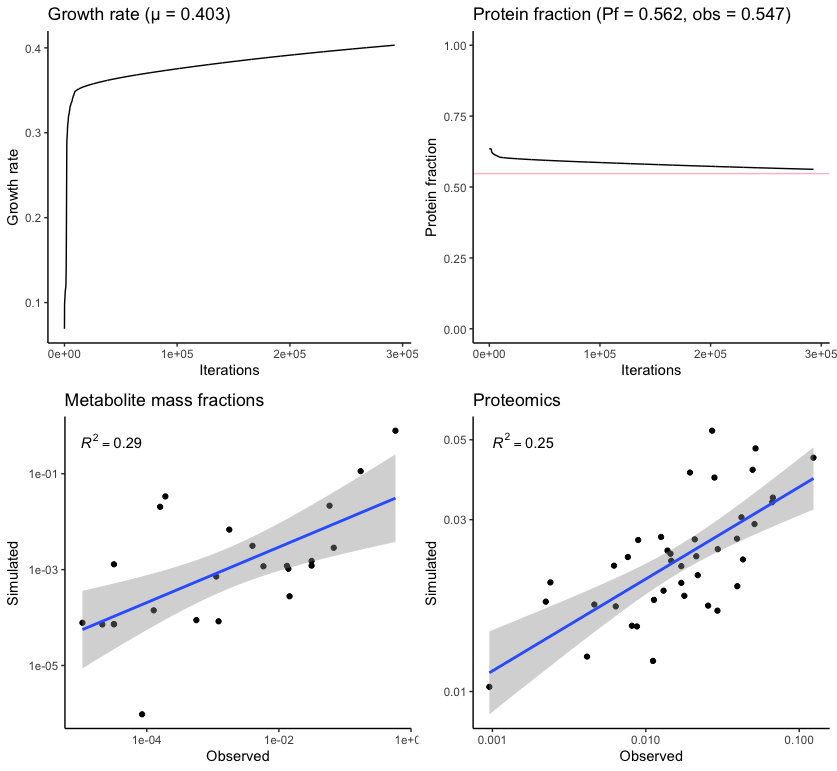